In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Question 1
This picture illustrates the Mixture of Experts block for an LLM:

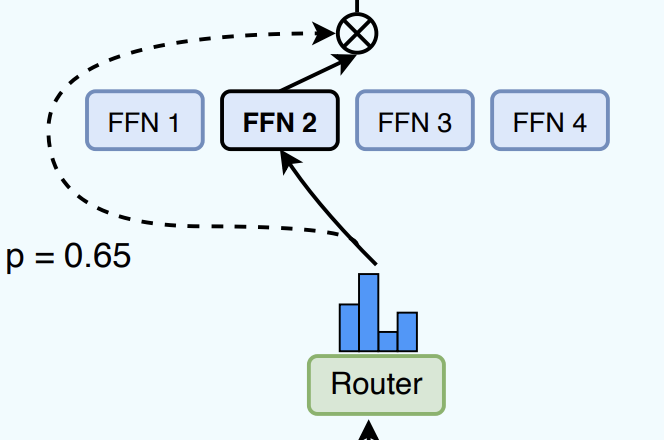
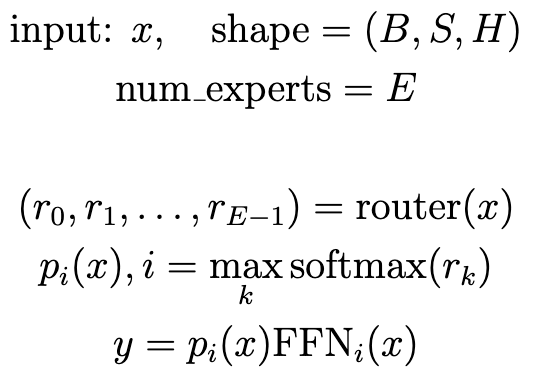

Write an MoE block starting from the template below

In [ ]:
class MLP(nn.Module):

  def __init__(self, hidden_size, ffn_hidden_size):
    super().__init__()
    # ...


  def forward(self, x):
    # x: (B, S, H)
    # ...



class MoE(nn.Module):

  def __init__(self, num_experts, hidden_size, ffn_hidden_size):
    super().__init__()
    self.router = nn.Linear(hidden_size, num_experts)
    self.experts = nn.ModuleList([MLP(hidden_size, ffn_hidden_size) for _ in range(num_experts)])


  def forward(self, x):
    # x: (B, S, H)
    scores = self.router(x) # (B, S, E)
    probs_0 = F.softmax(scores, dim=2) # (B, S, E)

    # ...

    for i, expert in enumerate(self.experts):
      # ...



x = torch.randn((2, 3, 5))
moe = MoE(4, 5, 20)
print(x)
print(moe(x))

# Question 1a

Test the forward pass of MoE (assuming the MLP works). You can do this line by line, in blocks, or whatever way you prefer.

# Question 2:

How would you encourage balanced expert usage?

# Question 2a:

This paper https://arxiv.org/pdf/2006.16668 proposes one way to address balanced expert usage:

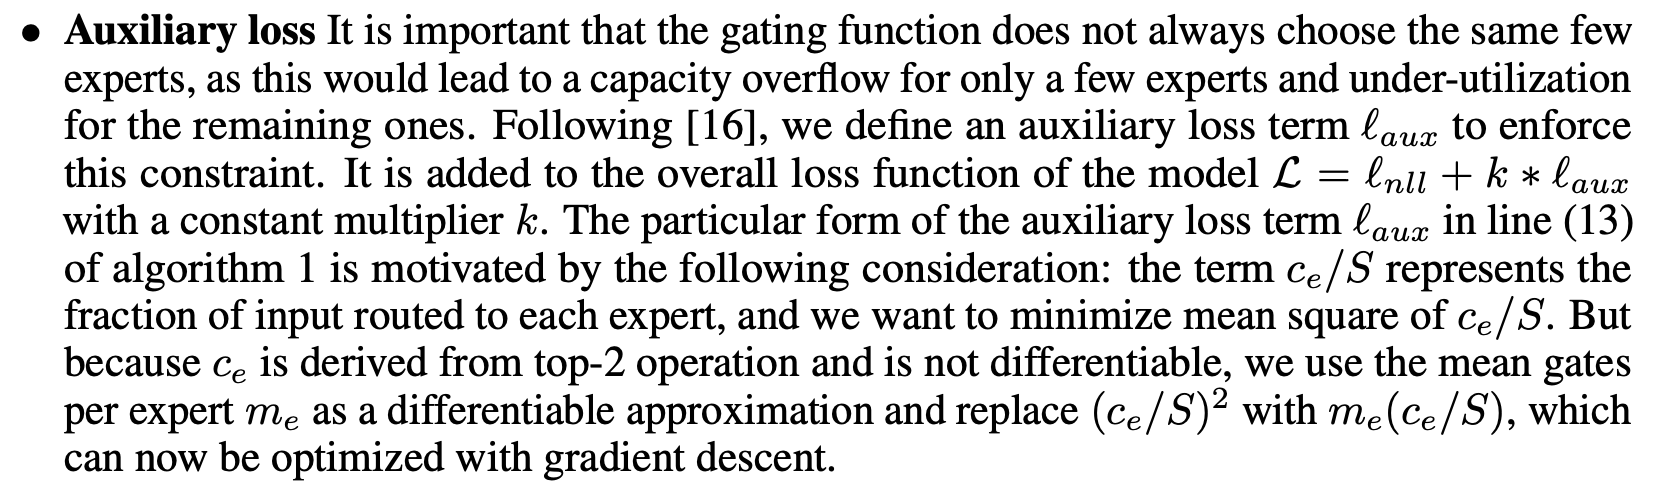
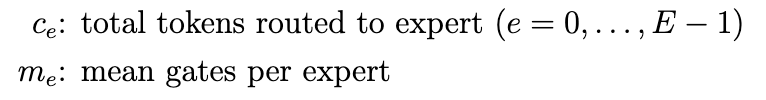

Implement it starting from this template:

In [ ]:
class MLP(nn.Module):

  def __init__(self, hidden_size, ffn_hidden_size):
    super().__init__()


  def forward(self, x):
    # x: (B, S, H)



class MoE(nn.Module):

  def __init__(self, num_experts, hidden_size, ffn_hidden_size):
    super().__init__()

    # previous code ...

    self.num_experts = num_experts



  def forward(self, x):
    # x: (B, S, H)

    # previous code ...

    if self.training:


      return output, bal_loss

    return output



x = torch.randn((2, 3, 5))
moe = MoE(4, 5, 20)
print(x)
print(moe(x))

# Question 3
Suppose we have a large MoE that doesn't fit a single GPU. We want to use data parallelism, which places different samples of the input batch across different GPUs, as well as distributing experts across all GPUs. This is called expert parallelism.

Example:
We have 2 GPUs with the following data parallel scheme (B is global batch size):
- GPU 0 has samples [0, 1, ..., B//2-1]
- GPU 1 has samples [B//2, B//2+1, ..., B-1]

We also split experts (say we have 4 experts):
- GPU 0 has experts [0, 1]
- GPU 1 has experts [2, 3].

Some of the samples located on GPU 0 may need to be processed by experts that are on GPU 1.

This means we need to send samples across GPUs.

In the template below, using pseudo-code (written in the comments), we add standard communication operations that allow transmitting samples across GPUs:

In [ ]:
class MoE(nn.Module):

  def __init__(self, num_experts, hidden_size, ffn_hidden_size):
    super().__init__()
    # router is shared across ranks
    self.router = nn.Linear(hidden_size, num_experts)

    # local expert indices:
    self.local_experts_ids = # list of integers ...

    # each rank has a distinct list of local experts
    self.local_experts = nn.ModuleList([Local_MLP(hidden_size, ffn_hidden_size) for _ in range(num_experts)])



  def forward(self, x):
    # x: (B, S, H)
    scores = self.router(x)
    probs_0 = F.softmax(scores, dim=2)
    probs, expert_ids = probs_0.max(dim=2)

    """
    all_gather:
    Input:  rank 0: tensor([1, 2]), rank 1: tensor([3, 4])
    Output: both ranks: tensor([1, 2, 3, 4])

    all_reduce:
    Input:  rank 0: tensor([1, 2]), rank 1: tensor([3, 4])
    Output: rank 0: tensor([4, 6]), rank 1: tensor([4, 6])

    scatter:
    Input: both ranks: tensor([1, 2, 3, 4])
    Output: rank 0: tensor([1, 2]), rank 1: tensor([3, 4])
    """

    "Which of the communication operations above are used in the commented steps below?"

    # global_expert_ids = torch.empty((<???>, expert_ids.shape[1]), dtype=local_indices.dtype, device=torch.cuda.current_device()
    # torch.distributed.<???>(global_expert_ids, expert_ids, group)

    # global_x = torch.empty((<???>, x.shape[1], x.shape[2]), dtype=x.dtype, device=torch.cuda.current_device()
    # torch.distributed.<???>(global_x, x)

    output_total = torch.zeros_like(global_x)

    for i, expert in enumerate(self.local_experts):
      local_expert_id = self.local_experts_ids[i]
      local_indices = (global_expert_ids == local_expert_id).nonzero()
      inp = global_hidden_states[local_indices, :]
      out = expert(inp)
      output_total[local_indices, :] = out

    # output_local = torch.empty((<???>, output_total.shape[1]), dtype=output_total.dtype, device=torch.cuda.current_device())
    # torch.distributed.<???>(output_local, output_total)

    output_local = output_local * probs.unsqueeze(-1)

    return output_local


x = torch.randn((2, 3, 5))
moe = MoE(4, 5, 20)
print(x)
print(moe(x))

How does load balancing help GPU utilization and efficiency?